# Range-Doppler Algorithm for SAR Processing
Processing of actual SAR data from the 80 GHz radar system

Using file: PointTargetData\2024-12-09T125446.hdf5


Using file: PointTargetData\2024-12-09T125446.hdf5


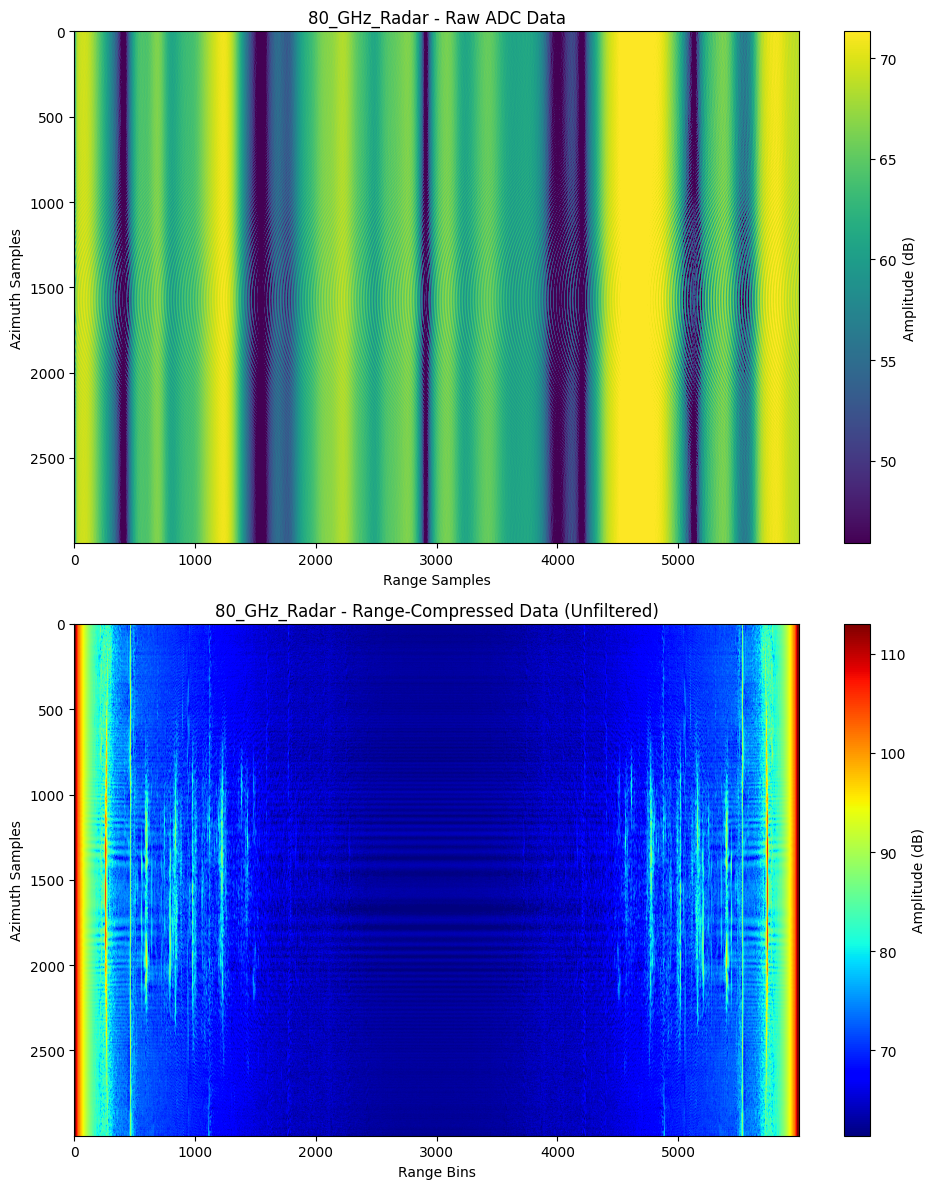

In [ ]:
import os.path
import h5py
import matplotlib.pyplot as plt
import numpy as np

###################################
# USER PARAMETERS
###################################
# Update the path to point to your HDF5 file
sar_scene_folder = "PointTargetData"
scene_name = "2024-12-09T125446"

print(f"Looking for files in: {os.path.abspath(sar_scene_folder)}")
print("Files in directory:")
for file in os.listdir(sar_scene_folder):
    print(f"- {file}")

# Directly use the known file with .hdf5 extension
data_name = os.path.join(sar_scene_folder, scene_name + ".hdf5")
print(f"Using file: {data_name}")

# Open the HDF5 file
with h5py.File(data_name, "r") as data:
    # First, let's print the structure of the HDF5 file
    print("HDF5 file structure:")
    def print_structure(name, obj):
        print(f"- {name} : {type(obj)}")
        if isinstance(obj, h5py.Dataset):
            print(f"  Shape: {obj.shape}, Type: {obj.dtype}")
    data.visititems(print_structure)
    
    ##################################
    # SIMPLIFIED PLOTTING
    ##################################
    radar_frequencies = ["80_GHz_Radar", "144_GHz_Radar", "240_GHz_Radar"]
    
    for radar in radar_frequencies:
        raw_data = data[f"{radar}/raw_adc"][()]
        
        # Create a figure with 2 rows and 1 column (stacked vertically)
        fig, axs = plt.subplots(2, 1, figsize=(10, 12))
        
        # Plot 1: Raw ADC data magnitude (dB scale)
        raw_magnitude = np.abs(raw_data)
        raw_db = 20 * np.log10(raw_magnitude + 1e-10)
        vmin_db, vmax_db = np.percentile(raw_db, [5, 95])
        im1 = axs[0].imshow(raw_db, aspect='auto', cmap='viridis', vmin=vmin_db, vmax=vmax_db)
        axs[0].set_title(f"{radar} - Raw ADC Data")
        axs[0].set_xlabel("Range Samples")
        axs[0].set_ylabel("Azimuth Samples")
        fig.colorbar(im1, ax=axs[0], label="Amplitude (dB)")
        
        # Plot 2: Range-compressed data without filtering
        # Perform range compression using FFT
        range_compressed = np.fft.fft(raw_data, axis=1)

        # No filtering - comment out the low-pass filter code
        # Apply ideal low-pass filter
        # n_range = range_compressed.shape[1]
        # cutoff = int(0.2 * n_range)  # Tunable 0.2 
        # Zero out the high-frequency components
        # range_compressed[:, cutoff:] = 0

        # Plot the full range compressed data (not just single-sided)
        range_compressed_db = 20 * np.log10(np.abs(range_compressed) + 1e-10)
        
        # Use reasonable dynamic range for visualization
        vmin_rc, vmax_rc = np.percentile(range_compressed_db, [10, 99.5])
        im2 = axs[1].imshow(range_compressed_db, aspect='auto', cmap='jet', vmin=vmin_rc, vmax=vmax_rc)
        axs[1].set_title(f"{radar} - Range-Compressed Data (Unfiltered)")
        axs[1].set_xlabel("Range Bins")
        axs[1].set_ylabel("Azimuth Samples")
        fig.colorbar(im2, ax=axs[1], label="Amplitude (dB)")
        
        plt.tight_layout()
        plt.show()

# Process raw data - use absolute values since we may have real data encoded oddly
raw_data_abs = np.abs(raw_data)
print(f"Taking absolute value of raw data (may help if data format is unusual)")

# Convert to dB scale for better visualization of dynamic range
raw_data_db = 20 * np.log10(raw_data_abs + 1e-10)  # Add small value to avoid log(0)
print(f"Converting to dB scale to enhance dynamic range visibility")

if not np.iscomplexobj(raw_data_abs):
    raw_data_abs = raw_data_abs.astype(np.float64)  # Use float since we're working with abs values

# Modified: Plot raw data with multiple representations including dB scale
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
im0 = axs[0, 0].imshow(np.real(raw_data), cmap='gray')
axs[0, 0].set_title("Raw Data: Real Part (Original)")
axs[0, 0].set_xlabel("Range Samples")
axs[0, 0].set_ylabel("Azimuth Samples")

# Use dB scale with percentile-based contrast limits
vmin_db, vmax_db = np.percentile(raw_data_db, [5, 95])
im1 = axs[0, 1].imshow(raw_data_db, cmap='viridis', vmin=vmin_db, vmax=vmax_db)
axs[0, 1].set_title("Raw Data: dB Scale")
axs[0, 1].set_xlabel("Range Samples")
axs[0, 1].set_ylabel("Azimuth Samples")
plt.colorbar(im1, ax=axs[0, 1], label="Amplitude (dB)")

# Regular magnitude plot
im2 = axs[1, 0].imshow(raw_data_abs, cmap='gray')
axs[1, 0].set_title("Raw Data: Magnitude (Linear)")
axs[1, 0].set_xlabel("Range Samples")
axs[1, 0].set_ylabel("Azimuth Samples")

# Apply contrast enhancement with sqrt and jet colormap for better visibility
enhanced = np.sqrt(raw_data_abs)  # Square root to enhance contrast
im3 = axs[1, 1].imshow(enhanced, cmap='jet')
axs[1, 1].set_title("Raw Data: Contrast Enhanced (sqrt)")
axs[1, 1].set_xlabel("Range Samples")
axs[1, 1].set_ylabel("Azimuth Samples")

plt.tight_layout()
plt.show()

# Print some data statistics to help understand the data
print(f"Raw data shape: {raw_data.shape}")
print(f"Raw data type: {raw_data.dtype}")
print(f"Real part - Min: {np.real(raw_data).min()}, Max: {np.real(raw_data).max()}")
print(f"Imag part - Min: {np.imag(raw_data).min()}, Max: {np.imag(raw_data).max()}")
print(f"Magnitude - Min: {np.abs(raw_data).min()}, Max: {np.abs(raw_data).max()}")
print(f"Abs processed - Min: {raw_data_abs.min()}, Max: {raw_data_abs.max()}")